In [15]:
# import Statements
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.ensemble import RandomForestClassifier

In [2]:
# loading training data set
training_dataset = pd.read_csv("data/ctweet/train.csv")

# Dropping neutral statements
training_dataset.drop(training_dataset[training_dataset['Y'] == 1].index, inplace=True)

# changing dataset value from 2 to 1 for classification.
training_dataset.loc[training_dataset['Y'] == 2, 'Y'] = 1

# Spliting training data set into the input and output
train_output = training_dataset["Y"]
train_input = training_dataset.drop(["Y"], axis=1)

In [3]:
# loading testing data set
testing_dataset = pd.read_csv("data/ctweet/test.csv")

# Dropping neutral statements
testing_dataset.drop(testing_dataset[testing_dataset['Y'] == 1].index, inplace=True)

# changing dataset value from 2 to 1 for classification.
testing_dataset.loc[testing_dataset['Y'] == 2, 'Y'] = 1

# Spliting testing data set into the input and output
testing_output = testing_dataset["Y"]
testing_input = testing_dataset.drop(["Y"], axis=1)

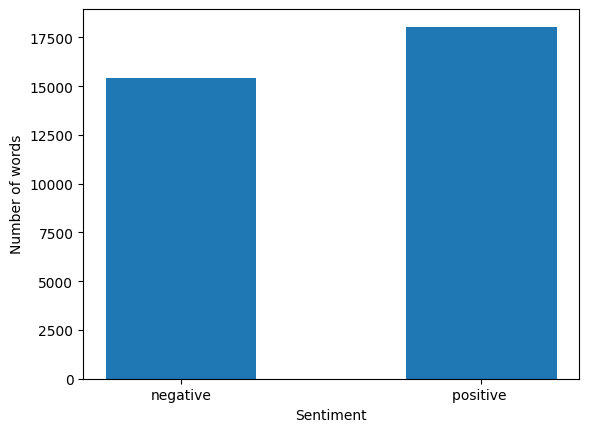

In [4]:
# Represent positive, negative and neutral data.
mapping = {0: "negative", 1: "positive "}
unique_output_dataset = training_dataset["Y"].unique()
sentiment_count = training_dataset.pivot_table(index=['Y'], aggfunc='size')

# maping 0,1,2 to Negative, Neutral, Positive
header_names = np.vectorize(lambda x: mapping.get(x, x))(unique_output_dataset)

# ploting
plt.bar(np.sort(header_names), sentiment_count, width = 0.5)
plt.ylabel('Number of words')
plt.xlabel('Sentiment')
plt.show()

### Data Processing

In [5]:
stopwords_list = set(stopwords.words("english"))
no_stopwords = {"not","don't",'aren','don','ain',"aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', 
                "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', 
                "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
                "wasn't", 'weren', "weren't", "won't", 'wouldn', "wouldn't"}

stopwords_list -= no_stopwords

In [6]:
vectorizer = TfidfVectorizer(max_features=20000, ngram_range = (1,2))
lemmatizer = WordNetLemmatizer()
re_negation = re.compile("n't ")
def extract_features(raw_input_text):

    def lemma_stem_text(words_list):
        # Lemmatizer
        text = [lemmatizer.lemmatize(token.lower()) for token in words_list]
        text = [lemmatizer.lemmatize(token.lower(), "v") for token in text]
        return text

    def negation_abbreviated_to_standard(sent):
        sent = re_negation.sub(" not ", sent)
        return sent

    def raw_text_to_meaningful_words(raw_text):
        # Transform abbreviated negations to the standard form
        standard_text = negation_abbreviated_to_standard(raw_text)
    
        # Remove non-letters and non-numbers
        letters_numbers_only = re.sub(r'[^a-zA-Z0-9\s]', '', standard_text)
    
        # Convert to lowercase and split into individual words (tokenization)
        words = letters_numbers_only.lower().split()
    
        # Remove stopwords and apply lemmatization
        meaningful_words = [lemmatizer.lemmatize(w) for w in words if w not in stopwords_list]
    
        # Join the words back into one string separated by space, and return the result
        return " ".join(meaningful_words)

    # making clean text
    clearn_input_text = [raw_text_to_meaningful_words(raw_text) for raw_text in raw_input_text]
    dataset_features = vectorizer.fit_transform(clearn_input_text)

    return dataset_features

In [7]:
train_data_features = extract_features(train_input['text'])

In [8]:
test_data_features = extract_features(testing_input["text"])

### Predictions

In [9]:
# Define the model
model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
# Train model
model.fit(train_data_features, train_output)

LogisticRegression(multi_class='multinomial', random_state=0)

In [10]:
print(model.score(test_data_features, testing_output))

0.49889902485058196


In [11]:
# Initialize a Random Forest classifier with 500 trees
forest = RandomForestClassifier(n_estimators = 500, max_depth = None, min_samples_split=2, min_samples_leaf =1,
                                bootstrap = True, random_state=0)

In [12]:
forest = forest.fit(train_data_features, train_output)

In [13]:
print(forest.score(test_data_features, testing_output))

0.4869455803711859


In [16]:
filename = "ctweet_prediction_model_random_forest.pkl"
pickle.dump(model, open(filename, "wb"))

In [17]:
# Save the CountVectorizer instance
with open("rf_count_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)